# Criteria for Truncated SVD: Python codes

In [48]:
#Necessary libraries to be imported:
import numpy as np
import scipy.linalg as spl
from scipy.interpolate import interp1d
import scipy.integrate as spi
from KDEpy import FFTKDE
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time


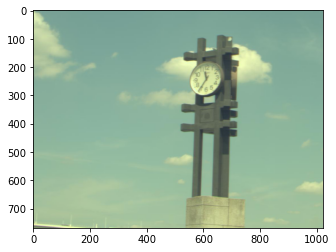

In [49]:
#Loading and plotting the firts image:
img = mpimg.imread('0002.jpg')
imgplot = plt.imshow(img)

shape of original image (768, 1024, 3)
shape gray scale (768, 1024)


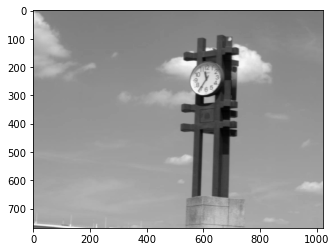

In [50]:
#Gray-scale transformation
print('shape of original image',img.shape)
rgb_weights = [0.2989, 0.5870, 0.1140]
imgg=np.dot(img,rgb_weights)
print('shape gray scale',imgg.shape)
imgplot = plt.imshow(imgg,cmap=plt.get_cmap("gray"))

In [51]:
#SVD computation
Uimg, sigm, Vimg = spl.svd(imgg, full_matrices=False)
r = np.linalg.matrix_rank(imgg)

# Scree plot


 Used time  in seconds to do the Scree plot: 0.10290122032165527


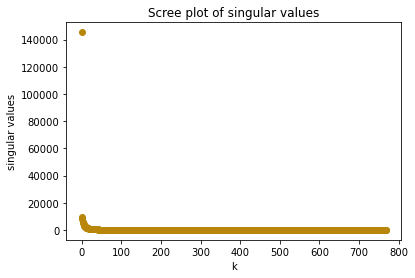

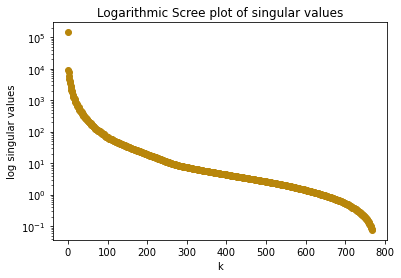

In [52]:
#Scree plot of the singular values
t = time.time()
plt.figure()
plt.plot(np.linspace(0,len(sigm),len(sigm)),sigm,'o', color='darkgoldenrod')
plt.title('Scree plot of singular values')
plt.xlabel('k')
plt.ylabel('singular values')
plt.figure()
plt.semilogy(np.linspace(0,len(sigm),len(sigm)),sigm,'o', color = 'darkgoldenrod')
plt.title('Logarithmic Scree plot of singular values')
plt.xlabel('k')
plt.ylabel('log singular values')
elapsed = time.time() - t
print('\n Used time  in seconds to do the Scree plot:', elapsed)

We use the logarithmic Scree plot as for the standard Scree plot is not easy to see the carachteristic "elbow" shape

In [53]:
Sigma_scree= sigm[0:300]*np.eye(300,300)
Rec_scree = np.dot(Uimg[:,0:300], np.dot(Sigma_scree,Vimg[0:300,:]))

print('\n Relative error with logarithmic Scree plot: ', np.linalg.norm(imgg-Rec_scree)/sigm[0])


 Relative error with logarithmic Scree plot:  0.00048448281963696854


# Guttman-Kaiser criterion

Choose the first $k$ singular values such that: $\forall i >k, \sigma_i<1$.


 Used time  in seconds for the Guttman-Keiser plot: 0.024935007095336914


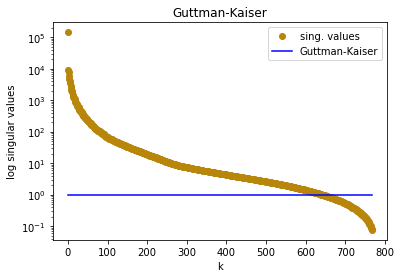

In [54]:
t = time.time()
plt.figure()
plt.semilogy(np.linspace(0,len(sigm),len(sigm)),sigm,'o', color='darkgoldenrod',label = 'sing. values')
plt.plot(np.linspace(0,len(sigm),len(sigm)), np.ones([len(sigm),1]),'-b', label = 'Guttman-Kaiser')
plt.title('Guttman-Kaiser')
plt.xlabel('k')
plt.ylabel('log singular values')
plt.legend()
elapsed = time.time() - t
print('\n Used time  in seconds for the Guttman-Keiser plot:', elapsed)

In [55]:
Sigma_GK= sigm[0:600]*np.eye(600,600)
Rec_GK = np.dot(Uimg[:,0:600], np.dot(Sigma_GK,Vimg[0:600,:]))

print('\n Relative error with Gutman-Kaiser criterion: ', np.linalg.norm(imgg-Rec_GK)/sigm[0])


 Relative error with Gutman-Kaiser criterion:  6.905372329328467e-05


# Broken-stick 

In [56]:
def brokenStick(s):
    l = len(s)
    b = np.zeros([1,l])

    for i in range(len(s)):
        
        b[0,i] = np.sum(np.linspace(i,l,l-i))
    
    return b/l

In [57]:
t = time.time()
br = brokenStick(sigm)
elapsed = time.time() - t
print('\n Broken-stick criterion computation in seconds', elapsed)


 Broken-stick criterion computation in seconds 0.046874046325683594


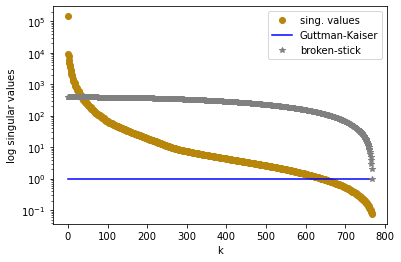

In [58]:
plt.figure()
plt.semilogy(np.linspace(0,len(sigm),len(sigm)),sigm,'o', color='darkgoldenrod',label = 'sing. values')
plt.plot(np.linspace(0,len(sigm),len(sigm)), np.ones([len(sigm),1]),'-b', label = 'Guttman-Kaiser')
plt.semilogy(np.linspace(0,len(sigm),len(sigm)), br[0,:], '*', color ='gray', label = 'broken-stick' )
#plt.title('')
plt.xlabel('k')
plt.ylabel('log singular values')
plt.legend()

In [59]:
Sigma_bstick= sigm[0:60]*np.eye(60,60)
Rec_bstick = np.dot(Uimg[:,0:60], np.dot(Sigma_bstick,Vimg[0:60,:]))

print('\n Relative error with broken-stick: ', np.linalg.norm(imgg-Rec_bstick)/sigm[0])


 Relative error with broken-stick:  0.005577044096581399


# Hard Thresholding Method

The code for the omega coefficient computation can be found in Matlab here:

D. L. Donoho and M. Gavish. (2014, Mar. 27). Code supplement to ‘the
optimal hard threshold for singular values is $4/\sqrt{3}$ [Online]. 
Available:
http://purl.stanford.edu/vg705qn9070


In [60]:
t = time.time()
ymedian = np.median(sigm)
omega = 2.502697248849711 # Matlab
tau_star = omega*ymedian
s_tau = sigm> tau_star
elapsed = time.time() - t
print('\n Time in seconds  %5 for the HT method ', elapsed)
print('\n indices of retained singular values\n',   np.nonzero(s_tau))


 Time in seconds  %5 for the HT method  0.00099945068359375

 indices of retained singular values
 (array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161

In [61]:
Sigma_tau= sigm[0:244]*np.eye(244,244)
Rec_tau = np.dot(Uimg[:,0:244], np.dot(Sigma_tau,Vimg[0:244,:]))

print('\n Relative error with Tresholding method: ', np.linalg.norm(imgg-Rec_tau)/sigm[0])


 Relative error with Tresholding method:  0.0006802486974626732


# Random-projection range finder

In [62]:
#Choose a tolerance:
tol = 1e-3

def range_finder(A,tol,max_it):
    
#Generate a list for the approximation error
    err = []
    err.append(1)
#Size of the input matrix    
    [m,n] = A.shape
    
    l = 1
    it = 0
    while((err[-1]>tol) & (it<max_it)):
    
#1. Draw an n × l Gaussian random matrix Ω
       Omega = np.random.randn(n,l)

#2. Form the m × l sample matrix Y = AΩ.
       Y = np.dot(A,Omega)

#3. Form an m × l orthonormal matrix Q such that Y = QR.
       [Q,R]=spl.qr(Y,pivoting=False)
    
#Add the error for this iteration
       err.append(np.linalg.norm(A- np.dot(Q[:,0:l],np.dot((Q[:,0:l]).T,A))))
       it = it+1
       l = l+1
    l = l-1
#4. Form the l × n matrix B = Q_l*A.
    B = np.dot((Q[:,0:l]).T, A)

#5. Compute the SVD of the small matrix B: B = \hat{U}ΣV*.
    [Uhat, Sigma, V] = spl.svd(B)

#6. Form the matrix U = Q_l(\hat{U}).
    U = np.dot(Q[:,0:l],Uhat)
    
    return l,err,it,U,Sigma,V

In [63]:
t = time.time()
k,error,n_it,Ur,Sigmar,Vr = range_finder(imgg,tol,100)
elapsed = time.time() - t
print('\n Used time in seconds for the range finder criterion ', elapsed)


 Used time in seconds for the range finder criterion  3.9062225818634033


In [64]:
print("\n Number of singular values ", k)
print("\n error at the last iteration ", error[-1])
print("\n Number of required iterations ", n_it)


 Number of singular values  100

 error at the last iteration  858.332379629877

 Number of required iterations  100


In [65]:
#Reconstructed image
Sigmarr = Sigmar[0:k]*np.eye(k,k)
Recon = np.dot(Ur, np.dot(Sigmarr,Vr[0:k,:]))

In [66]:
print("\n approximation error ", np.linalg.norm(imgg-Recon))
print ("\n sigma_{k+1} ", sigm[k+1])

print("\n Relative error ", np.linalg.norm(imgg-Recon)/sigm[0])



 approximation error  858.3323796298777

 sigma_{k+1}  65.49845842917813

 Relative error  0.005900957359829836


In this case we do not have the control of the error as the algoirthm exits due to maximal number of iterations reached rather than set accuracy reached.

# Entropy

In [67]:
t = time.time()
f = sigm**2/np.sum(sigm**2)
E = -1/np.log(r)*np.sum(f*np.log(f))
elapsed = time.time() - t
print('\n Used time in second for total entropy computation ', elapsed)
print('\n Entropy ', E)


 Used time in second for total entropy computation  0.0009989738464355469

 Entropy  0.015062674090159548


In [68]:
E_p70 = int(r*0.7*E) # 70% of total Entropy
print('\n number of singular values to retain to keep 70% ', E_p70)
E_p90 = int(r*0.9*E)
print('\n number of singular values to retain to keep 90% ', E_p90)

E_p100 = int(r*E)
print('\n number of singular values to retain to keep 100% ', E_p100)


 number of singular values to retain to keep 70%  8

 number of singular values to retain to keep 90%  10

 number of singular values to retain to keep 100%  11


In [69]:
t = time.time()
f_SVD = sigm/np.sum(sigm)
E_SVD = -1/np.log(r)*np.sum(f_SVD*np.log(f_SVD))
elapsed = time.time() - t
print('\n Time in second for the computation of the total Entropy_SVD criterion ', elapsed)
print('\n Entropy ', E_SVD)


 Time in second for the computation of the total Entropy_SVD criterion  0.0009653568267822266

 Entropy  0.317994382677596


In [70]:
E_SVD_p70 = int(r*0.7*E_SVD)
print('\n number of singular values to retain to keep E_SVD 70% ', E_SVD_p70)
E_SVD_p90 = int(r*0.9*E_SVD)
print('\n number of singular values to retain to keep E_SVD 90% ', E_SVD_p90)
E_SVD_p100 = int(r*E_SVD)
print('\n number of singular values to retain to keep E_SVD 100% ', E_SVD_p100)


 number of singular values to retain to keep E_SVD 70%  170

 number of singular values to retain to keep E_SVD 90%  219

 number of singular values to retain to keep E_SVD 100%  244


In [71]:
#Reconstructed image
Sigma_Ep70 = sigm[0:E_p70]*np.eye(E_p70,E_p70)
Sigma_Ep90 = sigm[0:E_p90]*np.eye(E_p90,E_p90)
Sigma_Ep100 = sigm[0:E_p100]*np.eye(E_p100,E_p100)

Sigma_SVD_Ep70 = sigm[0:E_SVD_p70]*np.eye(E_SVD_p70,E_SVD_p70)
Sigma_SVD_Ep90 = sigm[0:E_SVD_p90]*np.eye(E_SVD_p90,E_SVD_p90)
Sigma_SVD_Ep100 = sigm[0:E_SVD_p100]*np.eye(E_SVD_p100,E_SVD_p100)


Rec_Ep70 = np.dot(Uimg[:,0:E_p70], np.dot(Sigma_Ep70,Vimg[0:E_p70,:]))
Rec_Ep90 = np.dot(Uimg[:,0:E_p90], np.dot(Sigma_Ep90,Vimg[0:E_p90,:]))
Rec_Ep100 = np.dot(Uimg[:,0:E_p100], np.dot(Sigma_Ep100,Vimg[0:E_p100,:]))
Rec_SVD_Ep70 = np.dot(Uimg[:,0:E_SVD_p70], np.dot(Sigma_SVD_Ep70,Vimg[0:E_SVD_p70,:]))
Rec_SVD_Ep90 = np.dot(Uimg[:,0:E_SVD_p90], np.dot(Sigma_SVD_Ep90,Vimg[0:E_SVD_p90,:]))
Rec_SVD_Ep100 = np.dot(Uimg[:,0:E_SVD_p100], np.dot(Sigma_SVD_Ep100,Vimg[0:E_SVD_p100,:]))


print('\n Relative error with 70% ', np.linalg.norm(imgg-Rec_Ep70)/sigm[0])
print('\n Relative error with 90% ', np.linalg.norm(imgg-Rec_Ep90)/sigm[0])
print('\n Relative error with 100% ', np.linalg.norm(imgg-Rec_Ep100)/sigm[0])

print('\n Relative error with SVD 70% ', np.linalg.norm(imgg-Rec_SVD_Ep70)/sigm[0])
print('\n Relative error with SVD 90% ', np.linalg.norm(imgg-Rec_SVD_Ep90)/sigm[0])
print('\n Relative error with SVD 100% ', np.linalg.norm(imgg-Rec_SVD_Ep100)/sigm[0])


 Relative error with 70%  0.04216170665296159

 Relative error with 90%  0.0355028418238158

 Relative error with 100%  0.03281326312826331

 Relative error with SVD 70%  0.0013030580101773082

 Relative error with SVD 90%  0.0008266608790944184

 Relative error with SVD 100%  0.0006802486974626732


# Total variance

In [77]:
t = time.time()
tot_var = np.sum(sigm**2)
elapsed = time.time() - t
print('\n Time in seconds  for the total variance ', elapsed)
print('\n total variance as by the singular values', tot_var)
print('\n 10% of total variance as by the singular values ', 0.1*tot_var )


 Time in seconds  for the total variance  0.0

 total variance as by the singular values 21441023776.228905

 10% of total variance as by the singular values  2144102377.6228905


In [78]:
Corr_imgg = np.dot(imgg,imgg.T)
rC,cC = Corr_imgg.shape

for i in range(cC):
    Corr_imgg[:,i] = Corr_imgg[:,i]-np.mean(Corr_imgg[:,i])/np.std(Corr_imgg[:,i])

In [79]:
L, E = np.linalg.eig(Corr_imgg)

In [80]:
Tot_var_Corr = np.sum(L)
print('\n total variance correlation matrix ', Tot_var_Corr)
print('\n percentaige of variance explained by the first eigenvalue ', 100*L[0]/Tot_var_Corr )
print('\n percentaige of variance explained by the second eigenvalue ', 100*L[1]/Tot_var_Corr )

index = L>0.05*Tot_var_Corr 
print('\n number of eigenvalues explaining the 5% of total variance ', np.where(index==True) )


 total variance correlation matrix  21441010803.761154

 percentaige of variance explained by the first eigenvalue  98.67804086809596

 percentaige of variance explained by the second eigenvalue  0.4087990162446963

 number of eigenvalues explaining the 5% of total variance  (array([0], dtype=int64),)


In [81]:
#Reconstructed image
Sigma_var = sigm[0]*np.eye(1,1)
U_var = Uimg[:,0].reshape(768,1)
Recon_var = np.dot(U_var, np.dot(Sigma_var,Vimg[0,:].reshape(1,1024)))
print('\n Relative error Total Variance ', np.linalg.norm(imgg-Recon_var)/sigm[0])



 Relative error Total Variance  0.11574404746321416


# Percentage cumulative variance

In [82]:
t = time.time()
val = np.cumsum(L)/np.sum(L)
elapsed = time.time() - t
print('\n Time in seconds for the percentage cumulative varicance ', elapsed)
print('\n min value of val ', np.min(val))



 Time in seconds for the percentage cumulative varicance  0.0

 min value of val  0.9867804086809597


Since the first eigenvalue already hits 98% of the total variance, then by adding the contribution of the additional eigenvalue we exceed the set tolerance value by far.

# Kullback-Leibler divergence method

In [83]:
def divergence_KL(f,r,a,b,n_pts):
    grid = np.linspace(a,b,n_pts)
    T = []
    kde = FFTKDE( kernel='tri')
    x,y= kde.fit(f).evaluate()

# Mirror the data about the domain boundary
    low_bound = 0
    data = np.concatenate((f, 2 * low_bound - f))

# Compute KDE using the bandwidth found, i.e. the parameter h, and twice as many grid points
    x, y = FFTKDE(bw=kde.bw, kernel='tri').fit(data).evaluate()
    y[x<=low_bound] = 0  # Set the KDE to zero outside of the domain
    y = y * 2  # Double the y-values to get integral of ~1
    
    kde_t = FFTKDE( kernel='tri')
    for k in range(r):
        x_t,y_t= kde_t.fit(f[0:k+1]).evaluate()
# Mirror the data about the domain boundary
        low_bound = 0
        data_t = np.concatenate((f[0:k+1], 2 * low_bound - f[0:k+1]))

# Compute KDE using the bandwidth found, and twice as many grid points
        x_t, y_t = FFTKDE(bw=kde_t.bw, kernel='tri').fit(data_t).evaluate()
        y_t[x_t<=low_bound] = 0  # Set the KDE to zero outside of the domain
        y_t = y_t * 2  # Double the y-values to get integral of ~1
        
        #Linear spline necessary only if evaluation is done at non-uniform grid
        f_linear = interp1d(x, y, kind="linear", assume_sorted=True, fill_value="extrapolate")
        f_t_linear =interp1d(x_t, y_t, kind="linear", assume_sorted=True, fill_value="extrapolate")
        
        Eval_f = lambda x_grid: f_linear(x_grid)*np.log(f_linear(x_grid)/f_t_linear(x_grid))
        
        T.append(spi.trapz(Eval_f(grid),grid))
        
    return T

In [84]:
tol = 1e-3
t = time.time()
divergence = divergence_KL(f,r, 1e-13,3,30)
tupla = np.where(np.array(divergence)<tol)[0]
elapsed = time.time() - t
print('\n Time in seconds for the KL method ', elapsed)
print("\n Numer of singular values to retain ", tupla[0])


 Time in seconds for the KL method  1.486753225326538

 Numer of singular values to retain  58


In [85]:
Sigma_KL= sigm[0:tupla[0]]*np.eye(tupla[0],tupla[0])

Rec_KL = np.dot(Uimg[:,0:tupla[0]], np.dot(Sigma_KL,Vimg[0:tupla[0],:]))

print('\n Relative error with KL-method ', np.linalg.norm(imgg-Rec_KL)/sigm[0])


 Relative error with KL-method  0.00583031025952867


# Unsupervised anomaly detection based methods

In [86]:
t = time.time()
clf = IsolationForest(random_state=0, contamination = 0.05).fit_predict(sigm.reshape(-1,1)) #-1 outliers; 1 inliners
index_s = np.where(clf==-1)
index_s = index_s[0].astype(int)

Sigma_an1= sigm[index_s]*np.eye(len(index_s),len(index_s))
Rec_an1 = np.dot(Uimg[:,index_s], np.dot(Sigma_an1,Vimg[index_s,:]))
elapsed = time.time() - t
print('\n Time in seconds for the KIF method ', elapsed)
print(index_s)
print('\n Relative error with anomaly detection, first method: ', np.linalg.norm(imgg-Rec_an1)/sigm[0])


 Time in seconds for the KIF method  0.2833232879638672
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]

 Relative error with anomaly detection, first method:  0.009468801588735927


In [87]:
t = time.time()
kmeans = KMeans(n_clusters=2, random_state=0).fit(np.log(sigm.reshape(-1,1)))
lab = kmeans.labels_

Cl0 = np.where(lab==0)
Cl1 = np.where(lab==1)

l0 = len(Cl0[0])
l1 = len(Cl1[0])

if 0 in  Cl0[0]:
    clf2 = IsolationForest(random_state=0).fit_predict(np.log(sigm[Cl0[0]].reshape(-1,1))) #-1 outliers; 1 inliners
    #print("Cl0 ", Cl0)
else:
    clf2 = IsolationForest(random_state=0).fit_predict(np.log(sigm[Cl1[0]].reshape(-1,1))) #-1 outliers; 1 inliners
    #print("Cl1 ", Cl1)
indice = np.where(clf2==-1)
indice = indice[0].astype(int)
Last = np.where(np.diff(indice)>1)[0]
Last = Last[0]
elapsed = time.time() - t
print('\n Time in seconds for the KMIF method ', elapsed)
print("\n number of singular values to retain ", Last)


 Time in seconds for the KMIF method  0.2879488468170166

 number of singular values to retain  30


In [88]:
Sigma_an2= sigm[0:Last]*np.eye(Last,Last)
Rec_an2 = np.dot(Uimg[:,0:Last], np.dot(Sigma_an2,Vimg[0:Last,:]))

print('\n Relative error with anomaly detection, second method: ', np.linalg.norm(imgg-Rec_an2)/sigm[0])


 Relative error with anomaly detection, second method:  0.012825831283319914


In [89]:
Sigma_an2_full= sigm[indice]*np.eye(len(indice),len(indice))
Rec_an2_full = np.dot(Uimg[:,indice], np.dot(Sigma_an2_full,Vimg[indice,:]))

print('\n Relative error with anomaly detection, second method full: ', np.linalg.norm(imgg-Rec_an2_full)/sigm[0])


 Relative error with anomaly detection, second method full:  0.012147732311753973


Text(0.5, 1.0, 'KMeans-Isolation Forest,  k= 31')

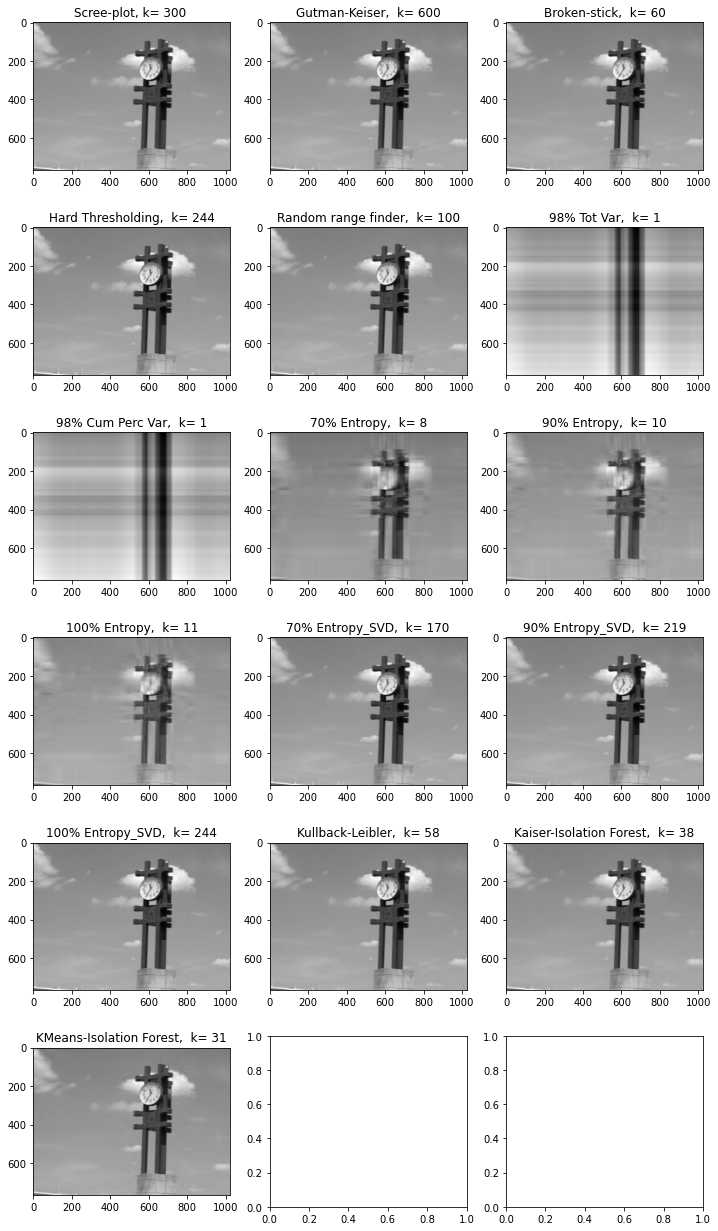

In [45]:
fig, axarr=plt.subplots(nrows=6, ncols=3, figsize=(12, 22))

axarr[0,0].imshow(Rec_scree, cmap='gray')
axarr[0,0].set_title("Scree-plot, k= 300 ")
axarr[0,1].imshow(Rec_GK, cmap='gray')
axarr[0,1].set_title("Gutman-Keiser,  k= 600")
axarr[0,2].imshow(Rec_bstick, cmap='gray')
axarr[0,2].set_title("Broken-stick,  k= 60")


axarr[1,0].imshow(Rec_tau, cmap = 'gray')
axarr[1,0].set_title("Hard Thresholding,  k= 244")


axarr[1,1].imshow(Recon, cmap='gray')
axarr[1,1].set_title("Random range finder,  k= 100")

axarr[1,2].imshow(Recon_var, cmap='gray')
axarr[1,2].set_title("98% Tot Var,  k= 1")

axarr[2,0].imshow(Recon_var, cmap='gray')
axarr[2,0].set_title("98% Cum Perc Var,  k= 1")

axarr[2,1].imshow(Rec_Ep70, cmap='gray')
axarr[2,1].set_title("70% Entropy,  k= 8")
axarr[2,2].imshow(Rec_Ep90, cmap='gray')
axarr[2,2].set_title("90% Entropy,  k= 10")

axarr[3,0].imshow(Rec_Ep100, cmap='gray')
axarr[3,0].set_title("100% Entropy,  k= 11")

axarr[3,1].imshow(Rec_SVD_Ep70, cmap='gray')
axarr[3,1].set_title("70% Entropy_SVD,  k= 170")
axarr[3,2].imshow(Rec_SVD_Ep90, cmap='gray')
axarr[3,2].set_title("90% Entropy_SVD,  k= 219")
axarr[4,0].imshow(Rec_SVD_Ep100, cmap='gray')
axarr[4,0].set_title("100% Entropy_SVD,  k= 244")

axarr[4,1].imshow(Rec_KL, cmap='gray')
axarr[4,1].set_title("Kullback-Leibler,  k= 58")
axarr[4,2].imshow(Rec_an1, cmap='gray')
axarr[4,2].set_title("Kaiser-Isolation Forest,  k= 38")

axarr[5,0].imshow(Rec_an2, cmap='gray')
axarr[5,0].set_title("KMeans-Isolation Forest,  k= 31")
#axarr[1,4].imshow(Rec_an2_full, cmap='gray')
#axarr[1,4].set_title("Anomaly detection 2, full")